# LeNet-5 with SVD
Author : Satrya Budi Pratama

In [1]:
import gzip
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import time

## Load Dataset

In [2]:
def read_mnist(images_path, labels_path):
    """
        This method load extracted file of MNIST
        input : images_path,labels_path
        return : features, labels
    """
    
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

### Training Data

In [3]:
data_train = {}
data_train_filename = "MNIST Dataset/train-images-idx3-ubyte.gz"
data_train_label_filename = "MNIST Dataset/train-labels-idx1-ubyte.gz"
data_train['X'], data_train['y'] = read_mnist(data_train_filename,data_train_label_filename)

### Testing Data

In [4]:
data_test = {}
data_test_filename = "MNIST Dataset/t10k-images-idx3-ubyte.gz"
data_test_label_filename = "MNIST Dataset/t10k-labels-idx1-ubyte.gz"
data_test['X'], data_test['y'] = read_mnist(data_test_filename, data_test_label_filename)

## Display Images

In [5]:
def display_image(position):
    image = data_train['X'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, data_train['y'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

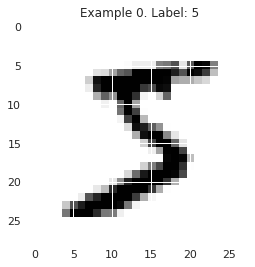

In [6]:
display_image(0)

## Observe the training data

In [7]:
train_labels_count = np.unique(data_train['y'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


The train data is balance for each class, it's good for a dataset to build a good model

## Shuffle and split the training data into training and validation

Shuffling and splitting our training data into 2 sets: train and validation. While leaving the test data unseen by our model until we are done with the training to avoid a self-fulfilling prophecy.

In [8]:
# shuffle
data_train['X'], data_train['y'] = shuffle(data_train['X'], data_train['y'])

In [9]:
# split into train and validation, 20% of validation data and 80% of training data
data_validation = {}
data_train['X'], data_validation['X'], data_train['y'], data_validation['y'] = train_test_split(data_train['X'], data_train['y'], test_size=0.2, random_state=0)

In [10]:
# check number of data train
len(data_train['X'])

48000

In [11]:
# check number of validation
len(data_validation['X'])

12000

## Prepare Input Images 
The LeNet architecture accepts a 32x32 pixel images as input, mnist data is 28x28 pixels. We simply pad the images with zeros to overcome that.

In [12]:
# Pad images with 0s
data_train['X']      = np.pad(data_train['X'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
data_validation['X'] = np.pad(data_validation['X'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
data_test['X']       = np.pad(data_test['X'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(data_train['X'][0].shape))

Updated Image Shape: (32, 32, 1)


## LeNet-5 Implementation

In [13]:
# parameters
EPOCHS = 50
BATCH_SIZE = 128
n_classes = 10
learning_rate = 0.0002

In [14]:
# Importing the required Keras modules containing model and layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, AveragePooling2D

def lenet5():
    model = Sequential()

    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(units=120, activation='relu'))

    model.add(Dense(units=84, activation='relu'))

    model.add(Dropout(0.2)) # add this droput to overcame overfitting

    model.add(Dense(units=10, activation = 'softmax'))

    return model


Using TensorFlow backend.


## Training Model without SVD

In [15]:
from keras.optimizers import Adam
model_without_svd = lenet5()
optimizer = Adam(lr=learning_rate)
model_without_svd.compile(optimizer= optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
original = model_without_svd.fit(x=data_train['X'],y=data_train['y'], epochs=EPOCHS,  
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(data_validation['X'], data_validation['y']))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 27s 559us/step - loss: 0.7188 - accuracy: 0.8255 - val_loss: 0.1560 - val_accuracy: 0.9535
Epoch 2/50
48000/48000 [==============================] - 25s 523us/step - loss: 0.1797 - accuracy: 0.9474 - val_loss: 0.1011 - val_accuracy: 0.9692
Epoch 3/50
48000/48000 [==============================] - 25s 522us/step - loss: 0.1192 - accuracy: 0.9641 - val_loss: 0.0876 - val_accuracy: 0.9750
Epoch 4/50
48000/48000 [==============================] - 25s 528us/step - loss: 0.0863 - accuracy: 0.9737 - val_loss: 0.0725 - val_accuracy: 0.9789
Epoch 5/50
48000/48000 [==============================] - 25s 527us/step - loss: 0.0706 - accuracy: 0.9777 - val_loss: 0.0616 - val_accuracy: 0.9826
Epoch 6/50
48000/48000 [==============================] - 25s 531us/step - loss: 0.0552 - accuracy: 0.9832 - val_loss: 0.0611 - val_accuracy: 0.9834
Epoch 7/50
48000/48000 [==============================] 

### Visualize the training process performance

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


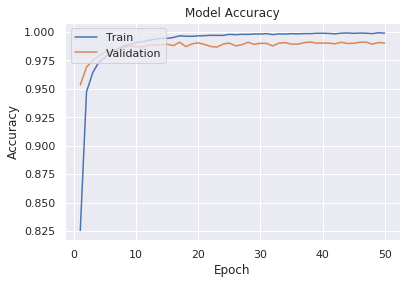

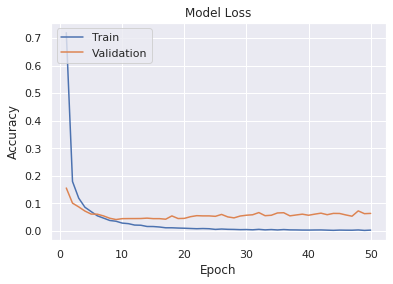

In [16]:
# Plot data
# list all data in history
print(original.history.keys())
# summarize history for accuracy
x_axis = np.arange(1,EPOCHS+1)
plt.plot(x_axis,original.history['accuracy'])
plt.plot(x_axis,original.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(x_axis,original.history['loss'])
plt.plot(x_axis,original.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testing Model without SVD

In [17]:
test_result = model_without_svd.evaluate(data_test['X'], data_test['y'])
print("Model Loss : {:.4f} - Accuracy : {:.4f}".format(test_result[0],test_result[1]))

10000/10000 [==============================] - 2s 218us/step
Model Loss : 0.0631 - Accuracy : 0.9899


## SVD Implementation

In [18]:
def get_reduced_data(features, number_of_components):
    """
    This method process all original data to low rank data using SVD, and reconstruct using some components.
    Result of the dimension of features is same, so no dimension reduction but keep the data lower.
    Input : features , number_of_components
    Output : reduced_features
    """
    
    reduced_features = []
    # iterate over features
    for i in range(len(features)):
        # obtain svd without the channel 32x32xC
        U, S, V = np.linalg.svd(features[i].squeeze())
        # construct the matrix to lower rank
        reduced_feature = U[:, :number_of_components] @ np.diag(S[:number_of_components]) @ V[:number_of_components , :]
        # append to the list and add channel again so 32x32x1
        reduced_features.append(reduced_feature[:,:,np.newaxis]) 
    
    return np.array(reduced_features) # convert from list to array

### Visualize the Image from reduced data

In [19]:
# components that we use, less than the original dimension
num_of_components = 6

# get SVD
U, S, V = np.linalg.svd(data_train['X'][0].squeeze())
# reconstruct the matrix to low rank matrix with 15 components 
low_rank = U[:, :num_of_components] @ np.diag(S[:num_of_components]) @ V[:num_of_components, :]
low_rank

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

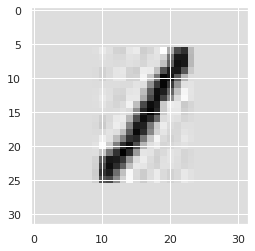

In [20]:
# show images
plt.imshow(low_rank.squeeze(), cmap=plt.cm.gray_r)

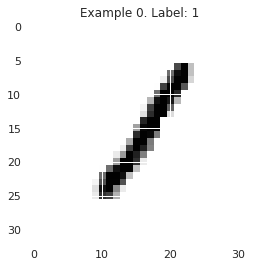

In [21]:
# original image
display_image(0)

### Get reduced data for Data Training, Data Validation, and Data Testing

In [22]:
data_train_SVD = get_reduced_data(data_train['X'], num_of_components)
data_test_SVD = get_reduced_data(data_test['X'], num_of_components)
data_validation_SVD = get_reduced_data(data_validation['X'], num_of_components)

## Training Model with SVD

In [23]:
model_with_svd = lenet5()
model_with_svd.compile(optimizer= optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model_svd = model_with_svd.fit(x=data_train_SVD,y=data_train['y'], epochs=EPOCHS,  
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(data_validation_SVD, data_validation['y']))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 24s 510us/step - loss: 0.2958 - accuracy: 0.9207 - val_loss: 0.0948 - val_accuracy: 0.9712
Epoch 2/50
48000/48000 [==============================] - 24s 507us/step - loss: 0.0980 - accuracy: 0.9713 - val_loss: 0.0723 - val_accuracy: 0.9787
Epoch 3/50
48000/48000 [==============================] - 24s 505us/step - loss: 0.0693 - accuracy: 0.9791 - val_loss: 0.0652 - val_accuracy: 0.9803
Epoch 4/50
48000/48000 [==============================] - 24s 505us/step - loss: 0.0555 - accuracy: 0.9825 - val_loss: 0.0590 - val_accuracy: 0.9826
Epoch 5/50
48000/48000 [==============================] - 24s 505us/step - loss: 0.0448 - accuracy: 0.9863 - val_loss: 0.0471 - val_accuracy: 0.9860
Epoch 6/50
48000/48000 [==============================] - 24s 503us/step - loss: 0.0365 - accuracy: 0.9887 - val_loss: 0.0520 - val_accuracy: 0.9849
Epoch 7/50
48000/48000 [==============================] 

### Visualize the training process performance

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


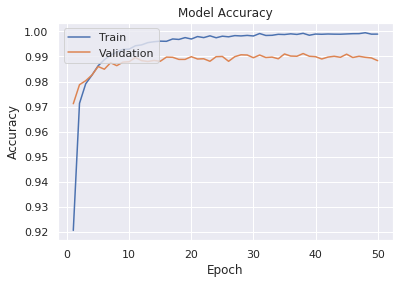

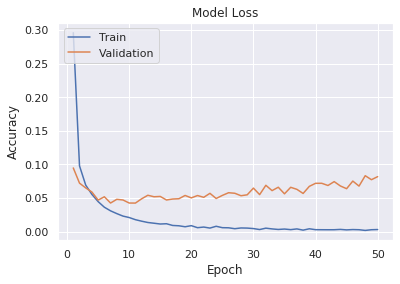

In [24]:
# Plot data
# list all data in history
print(model_svd.history.keys())
# summarize history for accuracy
x_axis = np.arange(1,EPOCHS+1)
plt.plot(x_axis,model_svd.history['accuracy'])
plt.plot(x_axis,model_svd.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(x_axis,model_svd.history['loss'])
plt.plot(x_axis,model_svd.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testing Model with SVD

In [25]:
test_result = model_with_svd.evaluate(data_test_SVD, data_test['y'])
print("Model Loss : {:.4f} - Accuracy : {:.4f}".format(test_result[0],test_result[1]))

10000/10000 [==============================] - 2s 230us/step
Model Loss : 0.0655 - Accuracy : 0.9876


## Observe the number of components to test result

In [26]:
acc_test_list = []
required_time_list = []
num_of_components_list = np.arange(2,32,2)
num_of_components_list

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])

In [27]:
model_with_svd = lenet5()
model_with_svd.compile(optimizer= optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
for num_components in num_of_components_list:
    print("\n")
    print("SVD Implementation with components {}".format(num_components))
    start_time = time.time()
    print("Preprocessing all data...")
    # pre processing
    data_train_SVD = get_reduced_data(data_train['X'], num_components)
    data_test_SVD = get_reduced_data(data_test['X'], num_components)
    data_validation_SVD = get_reduced_data(data_validation['X'], num_components)
    print("Training model...")
    # training
    model_with_svd.fit(x=data_train_SVD,y=data_train['y'], epochs=EPOCHS,  
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(data_validation_SVD, data_validation['y']))
    
    print("Testing model...")
    # testing
    test_result = model_with_svd.evaluate(data_test_SVD, data_test['y'])
    print("Model Loss : {:.4f} - Accuracy : {:.4f}".format(test_result[0],test_result[1]))
    required_time = time.time() - start_time
    print("--- %s seconds ---" % (required_time))
    acc_test_list.append(test_result[1]) # append accuracy result to list
    required_time_list.append(required_time)
    



SVD Implementation with components 2
Preprocessing all data...
Training model...
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 25s 525us/step - loss: 0.4959 - accuracy: 0.8646 - val_loss: 0.1994 - val_accuracy: 0.9391
Epoch 2/50
48000/48000 [==============================] - 25s 518us/step - loss: 0.2222 - accuracy: 0.9323 - val_loss: 0.1471 - val_accuracy: 0.9541
Epoch 3/50
48000/48000 [==============================] - 25s 525us/step - loss: 0.1748 - accuracy: 0.9474 - val_loss: 0.1321 - val_accuracy: 0.9590
Epoch 4/50
48000/48000 [==============================] - 25s 521us/step - loss: 0.1496 - accuracy: 0.9535 - val_loss: 0.1140 - val_accuracy: 0.9644
Epoch 5/50
48000/48000 [==============================] - 25s 525us/step - loss: 0.1324 - accuracy: 0.9586 - val_loss: 0.1112 - val_accuracy: 0.9659
Epoch 6/50
48000/48000 [==============================] - 25s 526us/step - loss: 0.1178 - accuracy: 0.9633 - val_loss: 0.1

Epoch 3/50
48000/48000 [==============================] - 25s 517us/step - loss: 0.0265 - accuracy: 0.9910 - val_loss: 0.0835 - val_accuracy: 0.9830
Epoch 4/50
48000/48000 [==============================] - 25s 517us/step - loss: 0.0218 - accuracy: 0.9927 - val_loss: 0.0735 - val_accuracy: 0.9836
Epoch 5/50
48000/48000 [==============================] - 25s 518us/step - loss: 0.0182 - accuracy: 0.9939 - val_loss: 0.0781 - val_accuracy: 0.9852
Epoch 6/50
48000/48000 [==============================] - 25s 516us/step - loss: 0.0142 - accuracy: 0.9954 - val_loss: 0.0792 - val_accuracy: 0.9849
Epoch 7/50
48000/48000 [==============================] - 25s 519us/step - loss: 0.0152 - accuracy: 0.9948 - val_loss: 0.0800 - val_accuracy: 0.9853
Epoch 8/50
48000/48000 [==============================] - 25s 520us/step - loss: 0.0131 - accuracy: 0.9953 - val_loss: 0.0905 - val_accuracy: 0.9839
Epoch 9/50
48000/48000 [==============================] - 25s 519us/step - loss: 0.0111 - accuracy: 0.9963

Epoch 6/50
48000/48000 [==============================] - 24s 505us/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0839 - val_accuracy: 0.9884
Epoch 7/50
48000/48000 [==============================] - 24s 505us/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.0851 - val_accuracy: 0.9890
Epoch 8/50
48000/48000 [==============================] - 24s 506us/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.0902 - val_accuracy: 0.9890
Epoch 9/50
48000/48000 [==============================] - 24s 506us/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.0930 - val_accuracy: 0.9880
Epoch 10/50
48000/48000 [==============================] - 24s 506us/step - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.0764 - val_accuracy: 0.9893
Epoch 11/50
48000/48000 [==============================] - 24s 508us/step - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.0910 - val_accuracy: 0.9883
Epoch 12/50
48000/48000 [==============================] - 24s 506us/step - loss: 0.0025 - accuracy: 0.9

Epoch 9/50
48000/48000 [==============================] - 24s 507us/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.1170 - val_accuracy: 0.9890
Epoch 10/50
48000/48000 [==============================] - 24s 504us/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.1007 - val_accuracy: 0.9896
Epoch 11/50
48000/48000 [==============================] - 24s 503us/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0917 - val_accuracy: 0.9895
Epoch 12/50
48000/48000 [==============================] - 24s 505us/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0991 - val_accuracy: 0.9894
Epoch 13/50
48000/48000 [==============================] - 24s 504us/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.1201 - val_accuracy: 0.9876
Epoch 14/50
48000/48000 [==============================] - 24s 508us/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.1067 - val_accuracy: 0.9895
Epoch 15/50
48000/48000 [==============================] - 24s 504us/step - loss: 0.0021 - accuracy: 

48000/48000 [==============================] - 24s 504us/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.1509 - val_accuracy: 0.9891
Epoch 12/50
48000/48000 [==============================] - 24s 506us/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.1397 - val_accuracy: 0.9898
Epoch 13/50
48000/48000 [==============================] - 24s 504us/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.1290 - val_accuracy: 0.9894
Epoch 14/50
48000/48000 [==============================] - 24s 504us/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.1296 - val_accuracy: 0.9896
Epoch 15/50
48000/48000 [==============================] - 24s 504us/step - loss: 9.0462e-04 - accuracy: 0.9996 - val_loss: 0.1269 - val_accuracy: 0.9892
Epoch 16/50
48000/48000 [==============================] - 24s 503us/step - loss: 9.2458e-04 - accuracy: 0.9998 - val_loss: 0.1264 - val_accuracy: 0.9893
Epoch 17/50
48000/48000 [==============================] - 24s 508us/step - loss: 0.0020 - accuracy: 0.9

48000/48000 [==============================] - 24s 509us/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.1429 - val_accuracy: 0.9893
Epoch 14/50
48000/48000 [==============================] - 24s 502us/step - loss: 7.2138e-04 - accuracy: 0.9998 - val_loss: 0.1511 - val_accuracy: 0.9892
Epoch 15/50
48000/48000 [==============================] - 24s 506us/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.1719 - val_accuracy: 0.9898
Epoch 16/50
48000/48000 [==============================] - 24s 502us/step - loss: 9.4816e-04 - accuracy: 0.9997 - val_loss: 0.1431 - val_accuracy: 0.9893
Epoch 17/50
48000/48000 [==============================] - 24s 505us/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.1530 - val_accuracy: 0.9902
Epoch 18/50
48000/48000 [==============================] - 24s 506us/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.1559 - val_accuracy: 0.9895
Epoch 19/50
48000/48000 [==============================] - 24s 505us/step - loss: 4.2930e-04 - accuracy:

48000/48000 [==============================] - 24s 506us/step - loss: 7.6591e-04 - accuracy: 0.9998 - val_loss: 0.1602 - val_accuracy: 0.9903
Epoch 16/50
48000/48000 [==============================] - 24s 504us/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.1610 - val_accuracy: 0.9908
Epoch 17/50
48000/48000 [==============================] - 24s 504us/step - loss: 5.5199e-04 - accuracy: 0.9998 - val_loss: 0.1989 - val_accuracy: 0.9897
Epoch 18/50
48000/48000 [==============================] - 24s 508us/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.1712 - val_accuracy: 0.9899
Epoch 19/50
48000/48000 [==============================] - 24s 509us/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.1634 - val_accuracy: 0.9903
Epoch 20/50
48000/48000 [==============================] - 24s 509us/step - loss: 9.2249e-05 - accuracy: 1.0000 - val_loss: 0.1562 - val_accuracy: 0.9906
Epoch 21/50
48000/48000 [==============================] - 24s 510us/step - loss: 0.0014 - accuracy:

48000/48000 [==============================] - 24s 505us/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.1845 - val_accuracy: 0.9896
Epoch 18/50
48000/48000 [==============================] - 24s 504us/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.1637 - val_accuracy: 0.9902
Epoch 19/50
48000/48000 [==============================] - 24s 505us/step - loss: 5.3689e-04 - accuracy: 0.9998 - val_loss: 0.1601 - val_accuracy: 0.9907
Epoch 20/50
48000/48000 [==============================] - 24s 504us/step - loss: 7.5021e-05 - accuracy: 1.0000 - val_loss: 0.1817 - val_accuracy: 0.9900
Epoch 21/50
48000/48000 [==============================] - 24s 504us/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.1868 - val_accuracy: 0.9893
Epoch 22/50
48000/48000 [==============================] - 24s 506us/step - loss: 7.0257e-04 - accuracy: 0.9998 - val_loss: 0.1857 - val_accuracy: 0.9899
Epoch 23/50
48000/48000 [==============================] - 24s 507us/step - loss: 8.1461e-04 - accur

48000/48000 [==============================] - 24s 506us/step - loss: 3.9894e-04 - accuracy: 0.9999 - val_loss: 0.2481 - val_accuracy: 0.9896
Epoch 20/50
48000/48000 [==============================] - 24s 506us/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.2300 - val_accuracy: 0.9896
Epoch 21/50
48000/48000 [==============================] - 24s 505us/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.2491 - val_accuracy: 0.9893
Epoch 22/50
48000/48000 [==============================] - 24s 507us/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.2495 - val_accuracy: 0.9891
Epoch 23/50
48000/48000 [==============================] - 24s 505us/step - loss: 3.9431e-04 - accuracy: 0.9999 - val_loss: 0.2470 - val_accuracy: 0.9893
Epoch 24/50
48000/48000 [==============================] - 24s 505us/step - loss: 8.7434e-04 - accuracy: 0.9998 - val_loss: 0.2185 - val_accuracy: 0.9893
Epoch 25/50
48000/48000 [==============================] - 24s 507us/step - loss: 7.7794e-04 - accur

48000/48000 [==============================] - 24s 509us/step - loss: 8.3751e-04 - accuracy: 0.9998 - val_loss: 0.2897 - val_accuracy: 0.9889
Epoch 22/50
48000/48000 [==============================] - 24s 504us/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.2467 - val_accuracy: 0.9895
Epoch 23/50
48000/48000 [==============================] - 24s 506us/step - loss: 2.7417e-04 - accuracy: 0.9999 - val_loss: 0.2256 - val_accuracy: 0.9899
Epoch 24/50
48000/48000 [==============================] - 24s 505us/step - loss: 9.1286e-04 - accuracy: 0.9998 - val_loss: 0.2391 - val_accuracy: 0.9883
Epoch 25/50
48000/48000 [==============================] - 24s 504us/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.2162 - val_accuracy: 0.9893
Epoch 26/50
48000/48000 [==============================] - 24s 504us/step - loss: 3.4388e-04 - accuracy: 0.9999 - val_loss: 0.2347 - val_accuracy: 0.9895
Epoch 27/50
48000/48000 [==============================] - 24s 504us/step - loss: 4.9994e-04 - a

48000/48000 [==============================] - 25s 514us/step - loss: 1.6347e-04 - accuracy: 1.0000 - val_loss: 0.2485 - val_accuracy: 0.9900
Epoch 24/50
48000/48000 [==============================] - 25s 513us/step - loss: 3.6902e-04 - accuracy: 0.9999 - val_loss: 0.2490 - val_accuracy: 0.9890
Epoch 25/50
48000/48000 [==============================] - 25s 514us/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.2496 - val_accuracy: 0.9899
Epoch 26/50
48000/48000 [==============================] - 25s 514us/step - loss: 6.6788e-04 - accuracy: 0.9998 - val_loss: 0.2454 - val_accuracy: 0.9880
Epoch 27/50
48000/48000 [==============================] - 25s 523us/step - loss: 3.0613e-04 - accuracy: 0.9998 - val_loss: 0.2347 - val_accuracy: 0.9895
Epoch 28/50
48000/48000 [==============================] - 24s 507us/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.2224 - val_accuracy: 0.9889
Epoch 29/50
48000/48000 [==============================] - 24s 509us/step - loss: 1.0607e-04 - a

Epoch 25/50
48000/48000 [==============================] - 26s 533us/step - loss: 6.8319e-04 - accuracy: 0.9999 - val_loss: 0.2647 - val_accuracy: 0.9887
Epoch 26/50
48000/48000 [==============================] - 25s 515us/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.2749 - val_accuracy: 0.9898
Epoch 27/50
48000/48000 [==============================] - 25s 515us/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.2772 - val_accuracy: 0.9895
Epoch 28/50
48000/48000 [==============================] - 25s 517us/step - loss: 6.0157e-04 - accuracy: 0.9999 - val_loss: 0.2496 - val_accuracy: 0.9891
Epoch 29/50
48000/48000 [==============================] - 25s 517us/step - loss: 9.7064e-04 - accuracy: 0.9998 - val_loss: 0.2186 - val_accuracy: 0.9900
Epoch 30/50
48000/48000 [==============================] - 25s 513us/step - loss: 4.8769e-04 - accuracy: 0.9999 - val_loss: 0.2961 - val_accuracy: 0.9902
Epoch 31/50
48000/48000 [==============================] - 25s 522us/step - loss: 4.

48000/48000 [==============================] - 25s 515us/step - loss: 3.9577e-04 - accuracy: 0.9999 - val_loss: 0.2335 - val_accuracy: 0.9901
Epoch 28/50
48000/48000 [==============================] - 25s 511us/step - loss: 2.4645e-04 - accuracy: 0.9999 - val_loss: 0.2660 - val_accuracy: 0.9899
Epoch 29/50
48000/48000 [==============================] - 25s 513us/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.3009 - val_accuracy: 0.9903
Epoch 30/50
48000/48000 [==============================] - 25s 512us/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.2326 - val_accuracy: 0.9893
Epoch 31/50
48000/48000 [==============================] - 25s 517us/step - loss: 8.7838e-04 - accuracy: 0.9998 - val_loss: 0.2615 - val_accuracy: 0.9897
Epoch 32/50
48000/48000 [==============================] - 25s 513us/step - loss: 6.8969e-04 - accuracy: 0.9998 - val_loss: 0.2868 - val_accuracy: 0.9895
Epoch 33/50
48000/48000 [==============================] - 25s 511us/step - loss: 0.0023 - accur

48000/48000 [==============================] - 26s 550us/step - loss: 3.3723e-04 - accuracy: 0.9999 - val_loss: 0.2761 - val_accuracy: 0.9890
Epoch 30/50
48000/48000 [==============================] - 28s 581us/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.2443 - val_accuracy: 0.9896
Epoch 31/50
48000/48000 [==============================] - 27s 554us/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.2822 - val_accuracy: 0.9898
Epoch 32/50
48000/48000 [==============================] - 28s 580us/step - loss: 9.7426e-04 - accuracy: 0.9998 - val_loss: 0.2417 - val_accuracy: 0.9903
Epoch 33/50
48000/48000 [==============================] - 26s 539us/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.2237 - val_accuracy: 0.9901
Epoch 34/50
48000/48000 [==============================] - 30s 626us/step - loss: 8.6192e-04 - accuracy: 0.9998 - val_loss: 0.2425 - val_accuracy: 0.9901
Epoch 35/50
48000/48000 [==============================] - 26s 535us/step - loss: 0.0014 - accuracy:

48000/48000 [==============================] - 27s 554us/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.2694 - val_accuracy: 0.9892
Epoch 32/50
48000/48000 [==============================] - 27s 558us/step - loss: 6.5995e-04 - accuracy: 0.9998 - val_loss: 0.2971 - val_accuracy: 0.9888
Epoch 33/50
48000/48000 [==============================] - 27s 568us/step - loss: 2.3618e-04 - accuracy: 0.9999 - val_loss: 0.2923 - val_accuracy: 0.9896
Epoch 34/50
48000/48000 [==============================] - 26s 535us/step - loss: 8.6419e-04 - accuracy: 0.9999 - val_loss: 0.3381 - val_accuracy: 0.9889
Epoch 35/50
48000/48000 [==============================] - 25s 528us/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.2963 - val_accuracy: 0.9897
Epoch 36/50
48000/48000 [==============================] - 28s 592us/step - loss: 5.9959e-04 - accuracy: 0.9999 - val_loss: 0.2876 - val_accuracy: 0.9898
Epoch 37/50
48000/48000 [==============================] - 27s 559us/step - loss: 8.0507e-04 - a

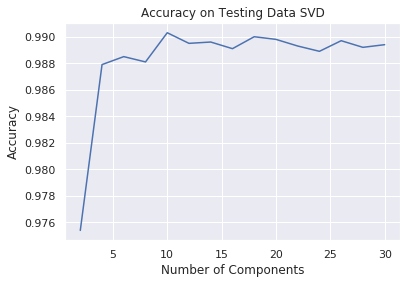

In [28]:
plt.plot(num_of_components_list,acc_test_list)
plt.title('Accuracy on Testing Data SVD')
plt.ylabel('Accuracy')
plt.xlabel('Number of Components')
plt.show()

10 number components of SVD gives the highest accuracy